### In this notebook, we apply `popsed` to GAMA photometry catalog.

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.

<stdin>:1:10: fatal error: cuda.h: No such file or directory
compilation terminated.



Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [7]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
name = 'NMF_ZH'
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=['.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh', 
                 'dust1', 'dust2', 
                 'dust_index', 'redshift'],  # , 'logm'
    device='cuda', use_speclite=True)

# gama_filters = ['sdss_{0}0'.format(b) for b in 'ugriz']# + ['VIKING_{0}'.format(b) for b in ['Y']]
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']# + ['VIKING_{0}'.format(b) for b in ['Y']]
#+ ['VIKING_{0}'.format(b) for b in ['Y', 'J', 'H', 'Ks']]
speculator._calc_transmission(gama_filters)
# speculator._calc_transmission(gama_filters, 
#                               filter_dir="/scratch/gpfs/jiaxuanl/Data/popsed/filters/gama")

In [8]:
speculator.ab_zero_counts

tensor([0.0015, 0.0109, 0.0098, 0.0071, 0.0012], device='cuda:0')

### Load Chang's params

In [9]:
params = np.load('./test_emu/provabgs.thetas.npy')
redshift = np.load('./test_emu/provabgs.redshifts.npy')

thetas = np.hstack([params, redshift[:, None]])
thetas = np.hstack([prior.FlatDirichletPrior(4).untransform(thetas[:, 1:5]), 
                    thetas[:, 5:-1],
                    thetas[:, -1:], thetas[:, 0:1]])

In [10]:
chang_mags = np.load('./test_emu/provabgs.sdss_photo.nanomaggies.npy')
chang_mags = 22.5 - 2.5 * np.log10(chang_mags)

In [11]:
test_par = torch.Tensor(thetas).to('cuda')
my_mags = speculator._predict_mag_with_mass_redshift(test_par,
                                                     noise=None).detach().cpu().numpy()

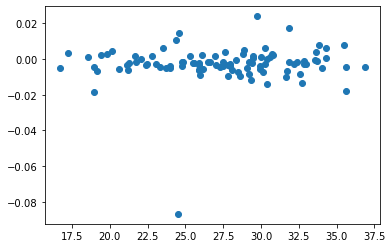

In [12]:
ind = 0
plt.scatter(chang_mags[:, ind], chang_mags[:, ind] - my_mags[:, ind])
# still have big problems

### Load Chang's specs

In [13]:
from popsed.models import lightspeed, to_cgs_at_10pc, jansky_cgs
from astropy.cosmology import Planck15 as cosmo

In [14]:
params = np.load('./test_emu/provabgs.thetas.z0p05.npy')
redshift = np.ones(len(params)) * 0.05

thetas = np.hstack([params, redshift[:, None]])
thetas = np.hstack([prior.FlatDirichletPrior(4).untransform(thetas[:, 1:5]), 
                    thetas[:, 5:-1],
                    thetas[:, -1:], thetas[:, 0:1]])
test_par = torch.Tensor(thetas).to('cuda')

In [15]:
wave = speculator.wave_obs.cpu().numpy()
chang_specs = np.load('./test_emu/provabgs.sed.z0p5.npy') * 1e-17
chang_wave = wave[wave >= 2000] * 1.05
# dfactor = np.log10((cosmo.luminosity_distance(0.05).value * 1e5)**2 * (1 + 0.05))
# my_specs = speculator._predict_spec_restframe(test_par[:, :]).detach().cpu().numpy() / 10**dfactor * to_cgs_at_10pc
my_specs = speculator._predict_spec_with_mass_redshift(test_par).detach().cpu().numpy()
my_mags = speculator._predict_mag_with_mass_redshift(test_par, 
                                                     filterset=gama_filters, 
                                                     noise=None).detach().cpu().numpy()

`parmas, logmstar, z`

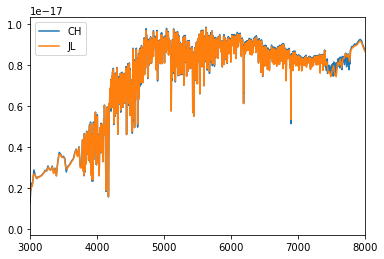

In [16]:
plt.plot(chang_wave, chang_specs[6], label='CH', zorder=0)
# ylim = plt.gca().get_ylim()
plt.plot(wave, my_specs[6], label='JL')
plt.xlim(3000, 8000)
# plt.ylim(ylim)
plt.legend()

In [17]:
# import speclite
import speclite.filters

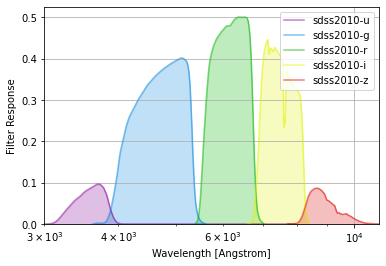

In [18]:
sdss = speclite.filters.load_filters('sdss2010-*')
speclite.filters.plot_filters(sdss, wavelength_limits=(3000, 11000))

# ax = plt.gca()
# from sedpy import observate
# filt_list = observate.load_filters(gama_filters, 
#                                    directory="/scratch/gpfs/jiaxuanl/Data/popsed/filters/gama")

# for filt in filt_list:
#     filt.display(ax=ax)
    
plt.xscale('log')

In [19]:
speculator._calc_transmission(gama_filters)
my_mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None).detach().cpu().numpy()

In [20]:
sdss = speclite.filters.load_filters('sdss2010-*')
lite_mag = np.vstack([
    sdss.get_ab_magnitudes(my_specs, wavelength=wave)[f'sdss2010-{filt}'] for filt in list('ugriz')]).T

In [21]:
# lite_i = sdss.get_ab_magnitudes(chang_specs, wavelength=wave[wave >= 2000] * 1.05)['sdss2010-i'].data

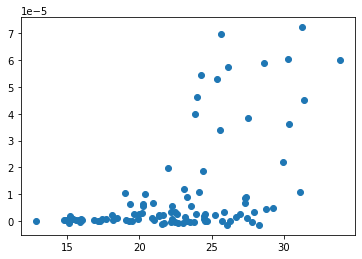

In [22]:
ind = 0
plt.scatter(lite_mag[:, ind], lite_mag[:, ind] - my_mags[:, ind])

In [29]:
from popsed.models import NMF_ZH
nmf = NMF_ZH()
nmf._load_NMF_bases()

Initialize NMF-based SPS model
Input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [31]:
nmf._parse_theta(params[0])

{'logmstar': array([8.19843975]),
 'beta1_sfh': array([0.61614155]),
 'beta2_sfh': array([0.32815272]),
 'beta3_sfh': array([0.02153662]),
 'beta4_sfh': array([0.03416911]),
 'fburst': array([0.28652619]),
 'tburst': array([10.83958401]),
 'gamma1_zh': array([0.00035194]),
 'gamma2_zh': array([9.34839552e-05]),
 'dust1': array([0.1059177]),
 'dust2': array([2.56723895]),
 'dust_index': array([-1.21191802])}

In [32]:
z_mw_list = [np.log10(nmf.Z_MW(params[i], zred=redshift[i])) for i in range(100)]
z_mw_list = np.array(z_mw_list).ravel() - (np.log10(0.0134))

In [55]:
thetas = np.hstack([params, redshift[:, None]])

In [59]:
thetas = np.hstack([prior.FlatDirichletPrior(4).untransform(thetas[:, 1:5]), 
                    thetas[:, 5:7], z_mw_list[:, None], thetas[:, 9:-1],
                    thetas[:, -1:], thetas[:, 0:1]])

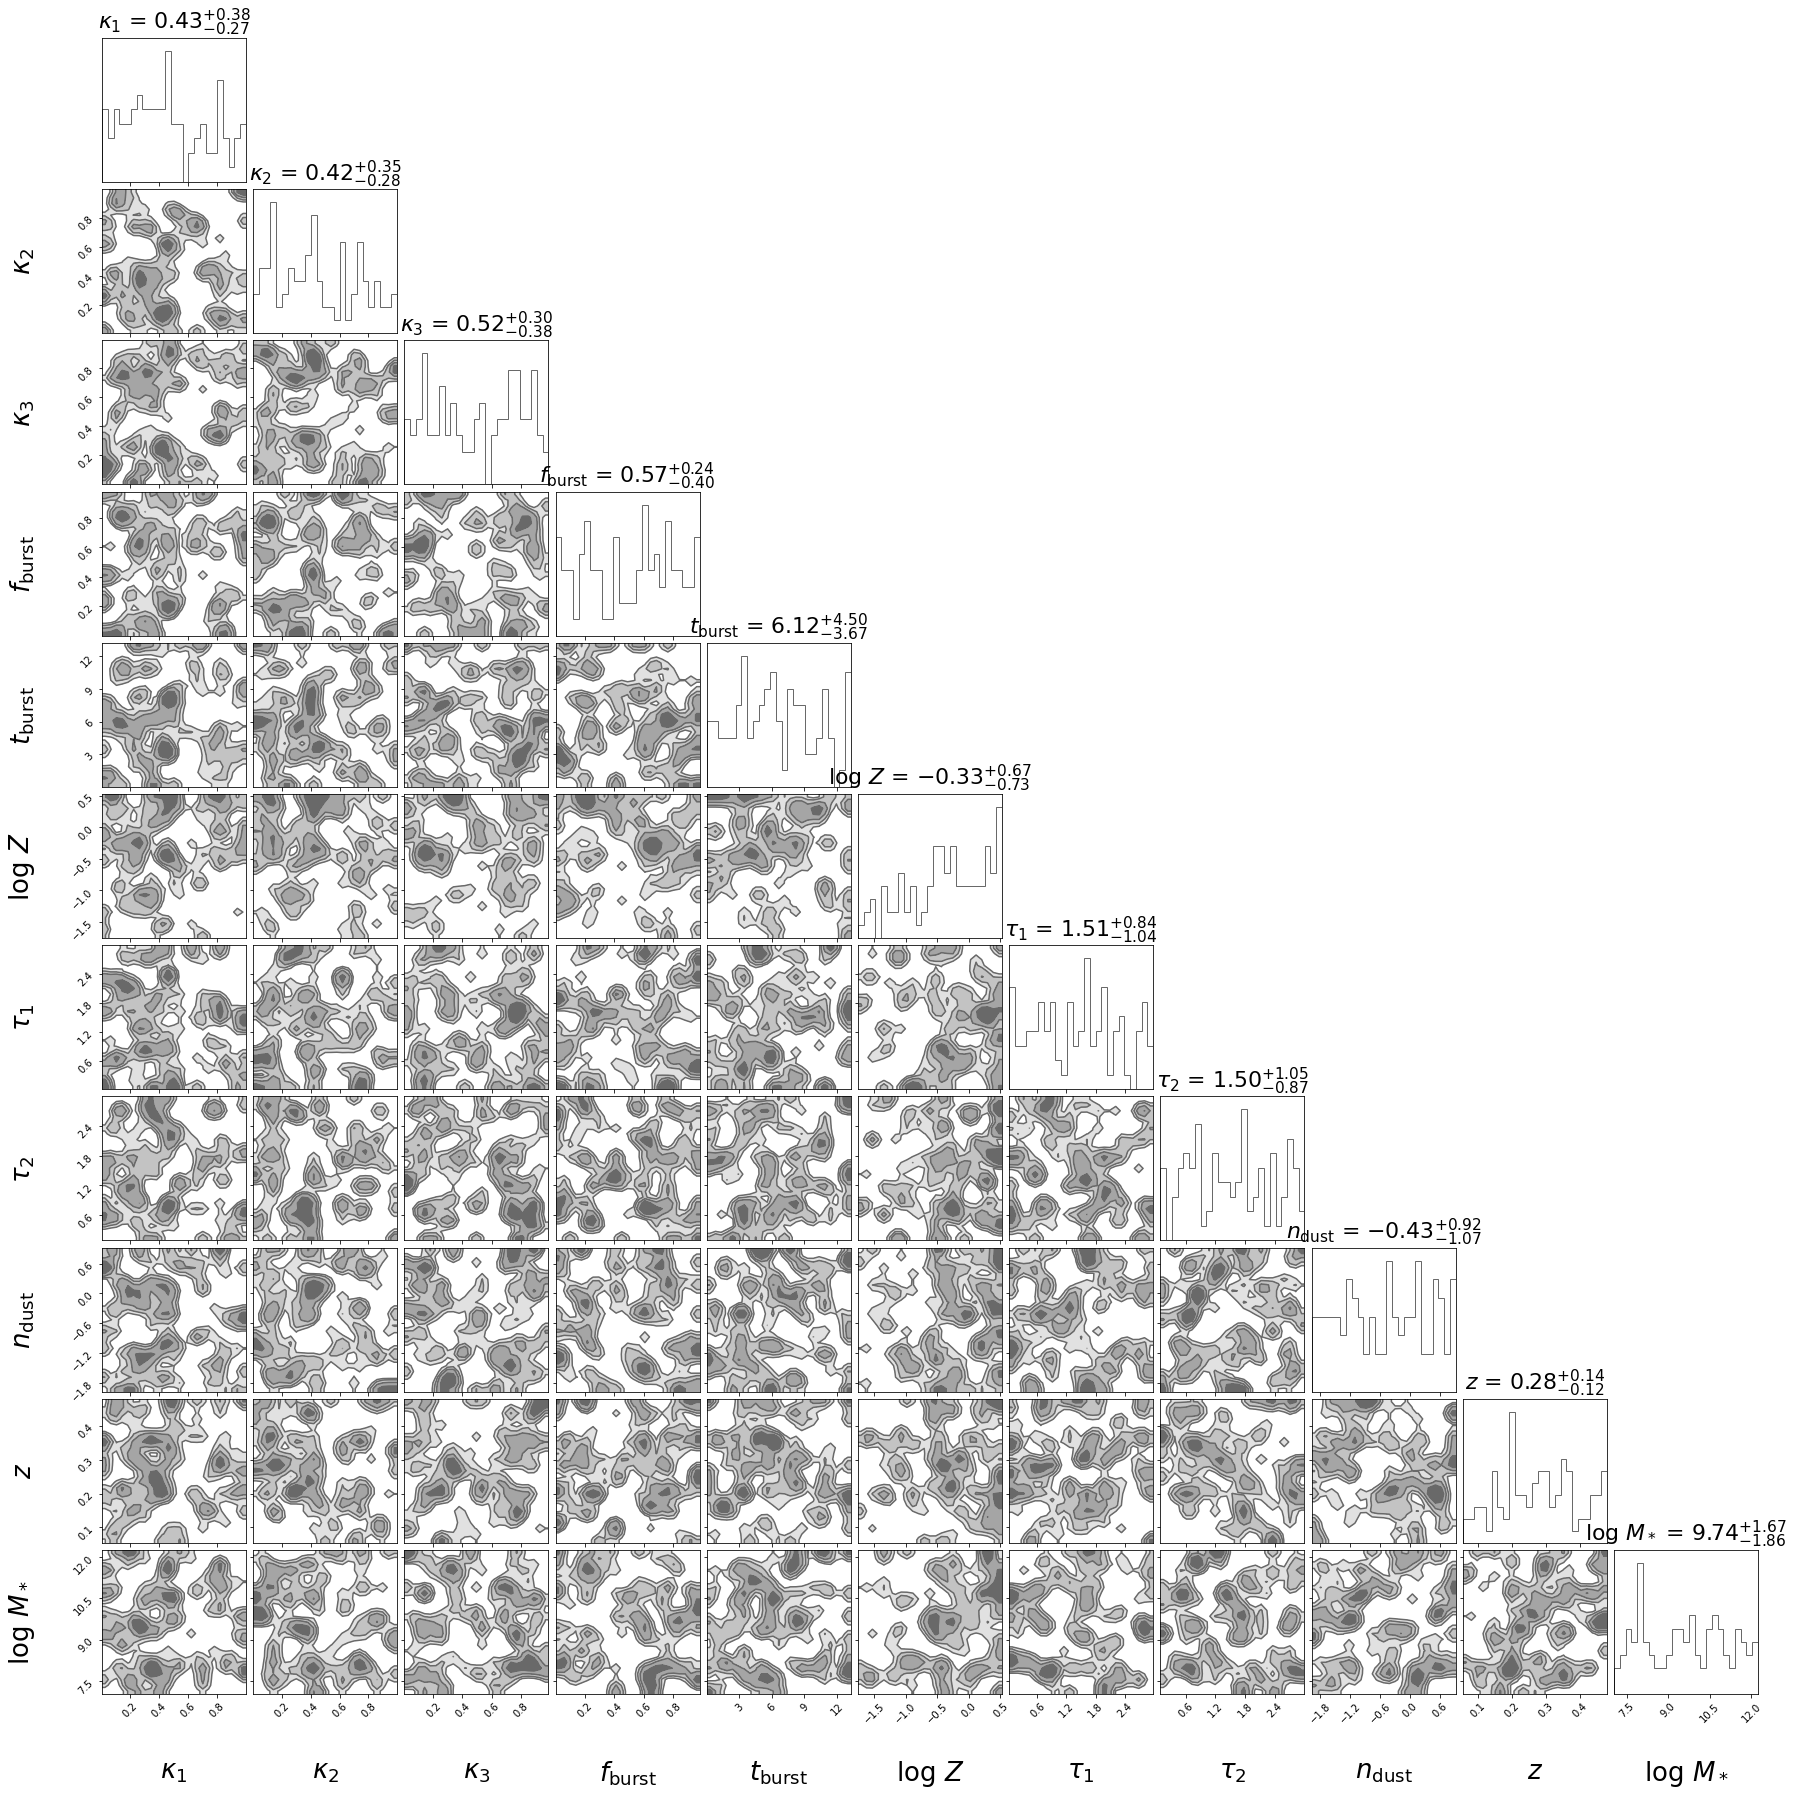

In [63]:
import matplotlib.lines as mlines

labels = [
    r'$\kappa_{1}$',
    r'$\kappa_{2}$',
    r'$\kappa_{3}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

# figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    thetas,
#     fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=1,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

In [91]:
test_par = torch.Tensor(thetas).to('cuda')
my_mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None).detach().cpu().numpy()

In [99]:
# test_par[:, 8] += 0.5

In [15]:
my_mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None).detach().cpu().numpy()

In [17]:
chang_mags = np.load('./test_emu/provabgs.sdss_photo.nanomaggies.npy')
chang_mags = 22.5 - 2.5 * np.log10(chang_mags)

Text(0, 0.5, "Mine - Chang's")

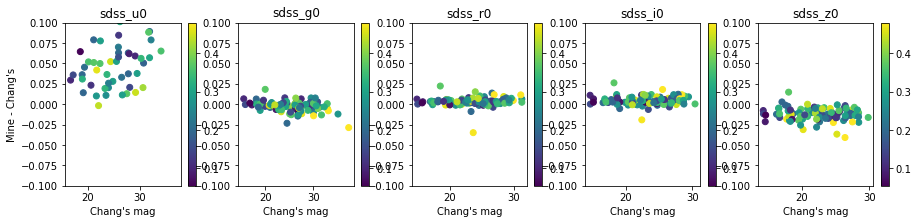

In [108]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    plt.sca(axes[i])
    plt.scatter(chang_mags[:, i], my_mags[:, i] - chang_mags[:, i], c=redshift)
    plt.colorbar()
    plt.title(gama_filters[i])
    plt.xlabel("Chang's mag")
    plt.ylim(-0.1, 0.1)
    
axes[0].set_ylabel("Mine - Chang's")

In [26]:
test_par[(chang_mags[:, 0] - my_mags[:, 0]) < 3]

tensor([[ 0.3839,  0.1451,  0.6134,  ..., -1.2119,  0.2575,  8.1984],
        [ 0.4706,  0.6385,  0.6992,  ...,  0.6102,  0.2292, 10.0164],
        [ 0.2793,  0.2945,  0.7247,  ..., -1.4448,  0.3529,  9.4058],
        ...,
        [ 0.1363,  0.3141,  0.2717,  ..., -0.1949,  0.2183,  9.4193],
        [ 0.5192,  0.1541,  0.1554,  ..., -0.4244,  0.4041, 10.6747],
        [ 0.1165,  0.8959,  0.7162,  ...,  0.7320,  0.1178, 10.8971]],
       device='cuda:0')

In [93]:
flag = np.abs(chang_mags[:, 0] - my_mags[:, 0]) > 3

In [106]:
y_spec = speculator._predict_spec_with_mass_redshift(
    test_par[flag]).detach().cpu().numpy()

In [102]:
y_spec = speculator._predict_spec_restframe(
    test_par[flag][:, :-1]).detach().cpu().numpy()

(1000.0, 8000.0)

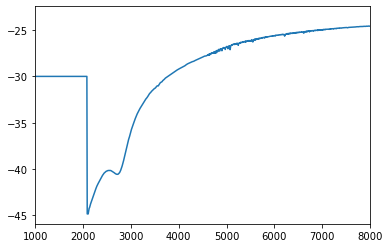

In [107]:
plt.plot(speculator.wavelength.cpu().numpy(), np.log10(y_spec[2]))
plt.xlim(1000, 8000)

In [97]:
my_mags[:, 0][flag] 

array([32.92716 , 40.262295, 43.513794, 36.992607, 40.680557, 34.37476 ,
       32.42725 , 51.030922, 35.031467], dtype=float32)

In [98]:
chang_mags[:, 0][flag]

array([29.73345845, 30.79763867, 36.8461677 , 32.54662331, 33.84149792,
       28.84738073, 27.93861795, 35.58866836, 28.33061633])

Text(0, 0.5, "Mine - Chang's")

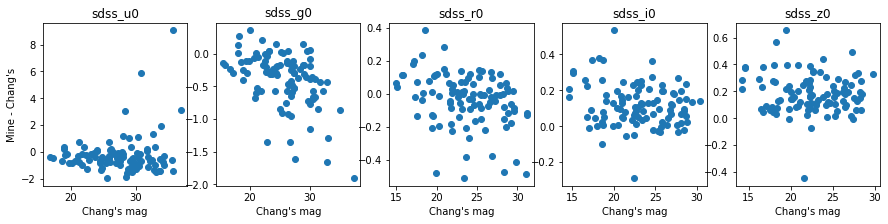

In [102]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    plt.sca(axes[i])
    plt.scatter(chang_mags[:, i], my_mags[:, i] - chang_mags[:, i])
    plt.title(gama_filters[i])
    plt.xlabel("Chang's mag")
    
axes[0].set_ylabel("Mine - Chang's")

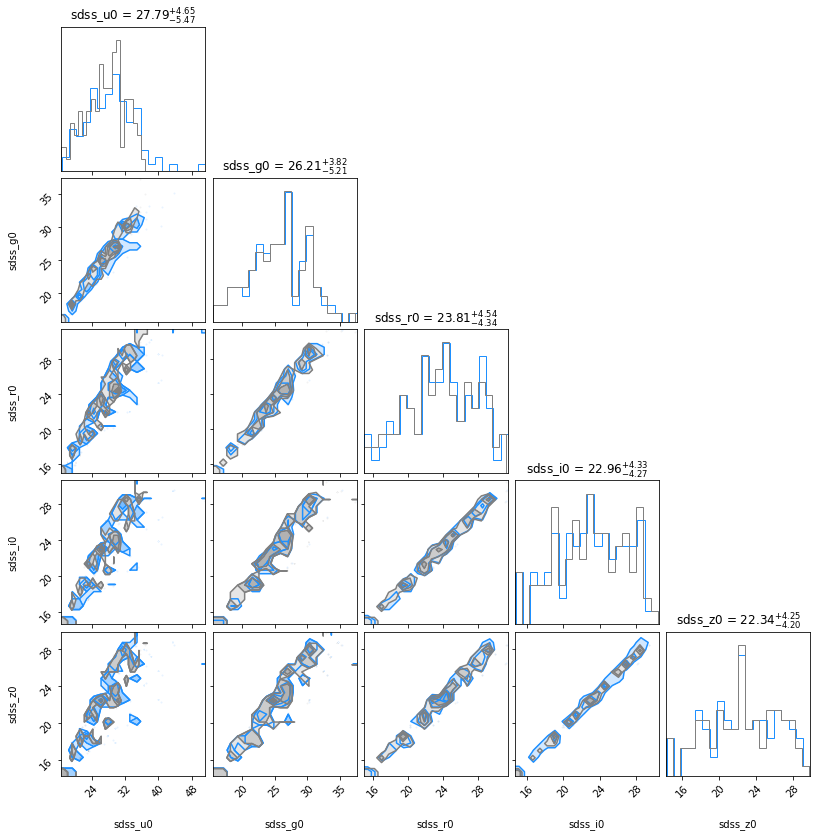

In [76]:
labels = gama_filters

figure = corner.corner(my_mags,
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

figure = corner.corner(chang_mags,
                       fig=figure,
                       color='gray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})


---

### Generate sample for Chang

In [103]:
params = np.load('./test_emu/jiaxuan_params.npy')

In [120]:
params[0]

array([ 0.61602461,  0.08442861,  0.28245783,  0.01708893,  0.85485089,
        8.6070118 ,  0.17126131,  2.32670093,  0.4754464 , -2.4278183 ,
        0.57955688,  9.35332394])

In [ ]:
beta_1, beta_2, beta_3, beta_4, fburst, tburst, logZsol, tau1, tau2, n_dust, redshift, logmstar

In [108]:
params_unt = np.hstack([prior.FlatDirichletPrior(4).untransform(params[:, :4]),
                      params[:, 4:-1], 
                      params[:, -1:]])

In [116]:
np.save('./test_emu/jiaxuan_params_kappa.npy', params_unt)

In [117]:
test_par = torch.Tensor(params_unt).to('cuda')
my_mags = speculator._predict_mag_with_mass_redshift(test_par, noise=None).detach().cpu().numpy()

In [118]:
params[0]

array([ 0.61602461,  0.08442861,  0.28245783,  0.01708893,  0.85485089,
        8.6070118 ,  0.17126131,  2.32670093,  0.4754464 , -2.4278183 ,
        0.57955688,  9.35332394])

In [119]:
np.save('./test_emu/jiaxuan_mags.npy', my_mags)

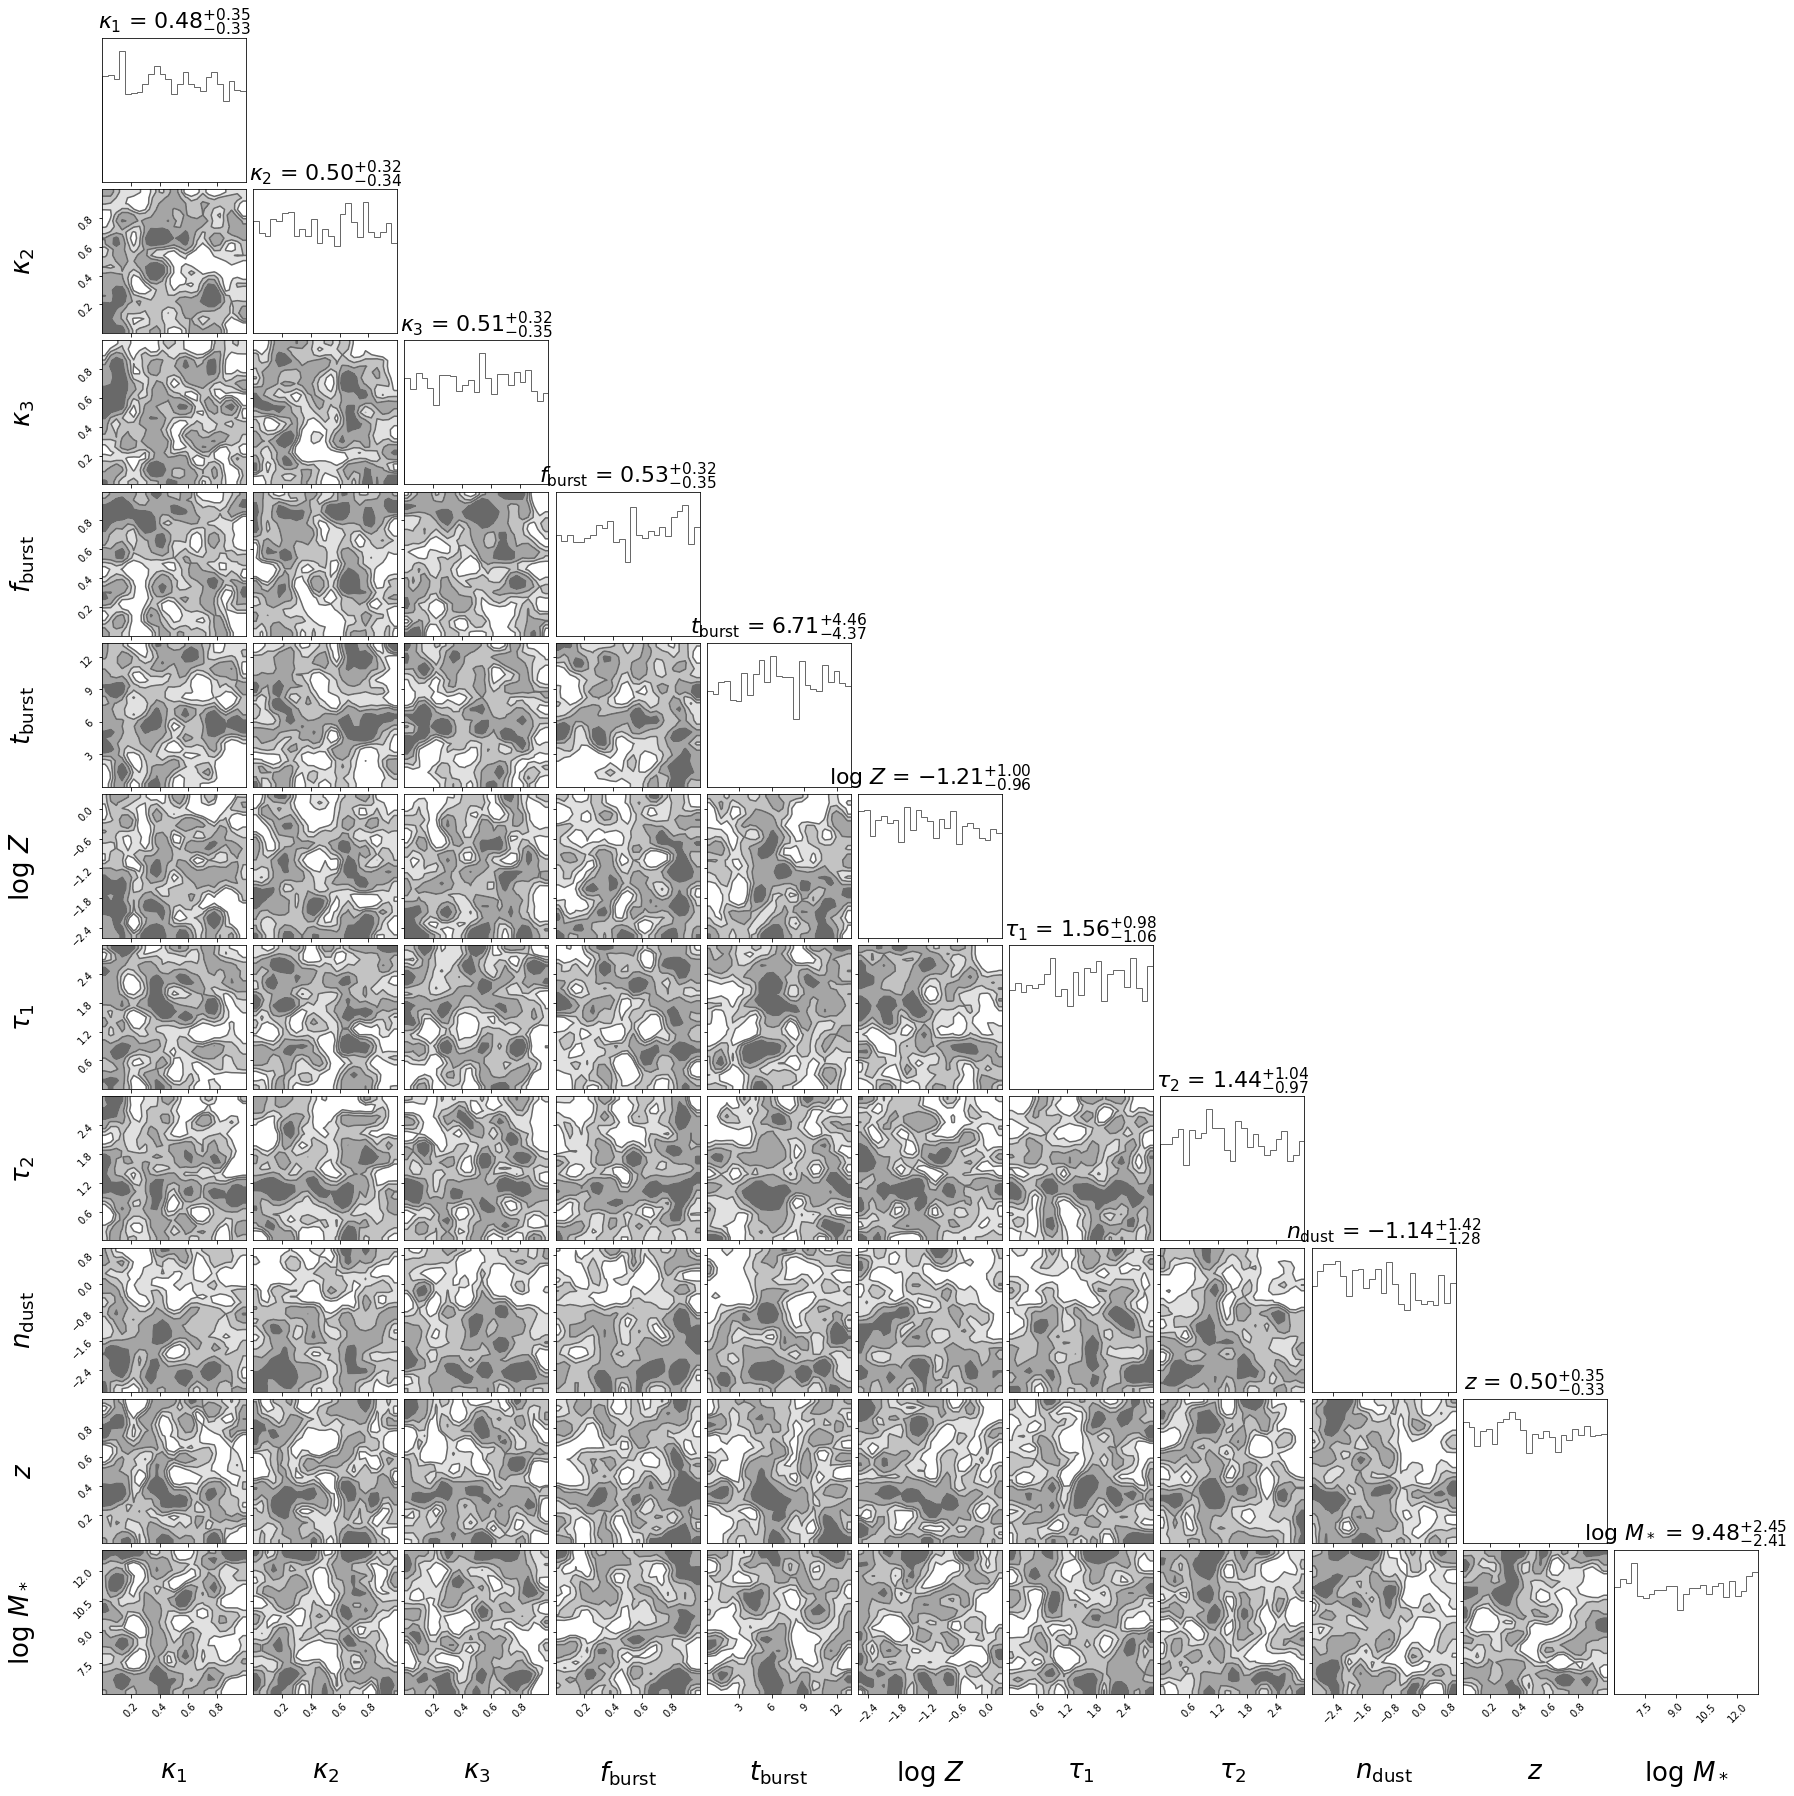

In [115]:
import matplotlib.lines as mlines

labels = [
    r'$\kappa_{1}$',
    r'$\kappa_{2}$',
    r'$\kappa_{3}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

# figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    params_unt,
#     fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=1,
    fill_contours=True,
    show_titles=True,
#     title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

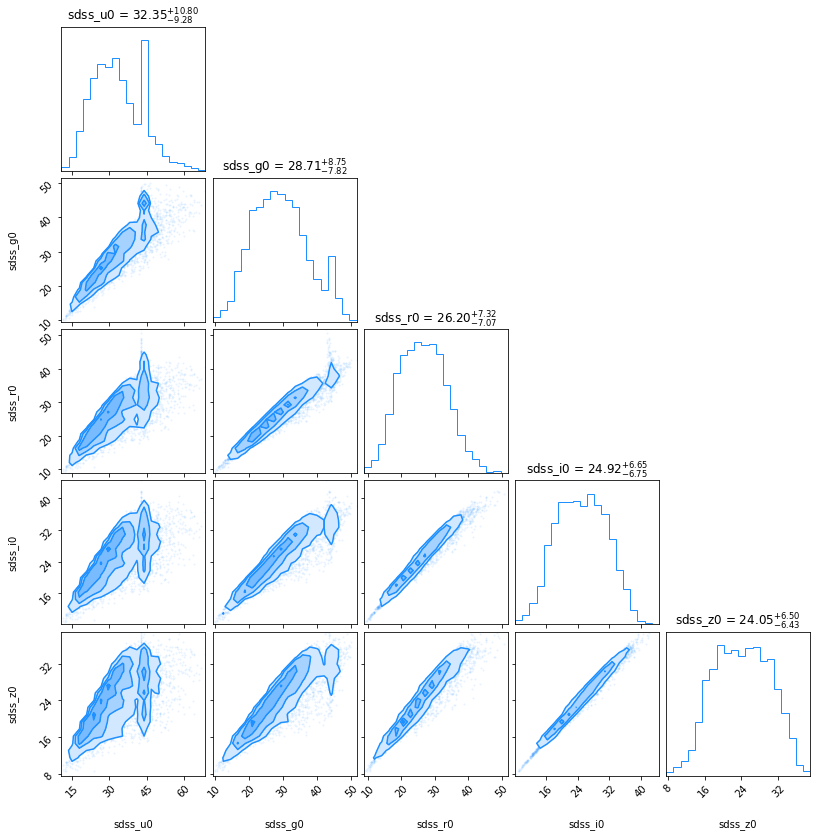

In [113]:
labels = gama_filters

figure = corner.corner(my_mags,
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# figure = corner.corner(chang_mags,
#                        fig=figure,
#                        color='gray', labels=labels,
#                        #quantiles=[0.16, 0.5, 0.84], 
#                        smooth=0.1, fill_contours=True,
#                        show_titles=True, 
#                        title_kwargs={"fontsize": 12},
#                        hist_kwargs={'density': True})
